# This notebook shall serve as a base to experiment with simple API calls from the DocuCam API.

Objectives, write scripts for:

* Obtain an image for a specific timestamp. 
* Obtain images for a specific time range (1day+)
* Understand the data structure --> Full Images and their respective layers (500?). How to obtain them.
* Obtain image + layers or only specific layers. 

In the end, we would want to have a script that takes some parameters as input (time range, location, quality, etc) and outputs a dataframe that combines both: Measurements per timestamp and the image plus the respective layers per timestamp. Images may be appended as simple numerical representations OR in the first step simply provide path to were image is stored. 

Problem: time stamps not in sync. Need to create a costum common identifier? 


# Swagger API address:

https://langenthal.hesotech.eu/DocuCam/api/index.html

In [15]:
import requests
import copy
import pandas as pd
from IPython.display import Image, display

# set src folder as default path to easily import helper functions
import glob, os, sys; sys.path.append('../src')

# import utils from src
import utils as util

### Import data, certificates and keys for access

In [16]:
# import all scans with respective timestamps from scene 0 (A1)
scene_0_df = pd.read_json("../data/scene_0_scans.json")
d = scene_0_df.to_dict(orient = 'records')

# certs and keys
clientCrt = "../certificates/pilot-users.crt"
clientKey = "../certificates/pilot-users.key"

In [4]:
# example query to get the latest image from scene 0 (A1), layer 1, column 1, row 1.

url = "https://langenthal.hesotech.eu/DocuCam/Image/0/1/1/1/latest"

headers = {'content-type': 'image/jpeg'}

r = requests.get(url, headers=headers, cert=(clientCrt, clientKey))

In [5]:
r

<Response [200]>

Now we prototype a query function that takes the parameters as inputs and returns url and singe image. Let's put this one in the src folder for later use/improvements. 

In [6]:
def query_image(scence, layer, column, row, timestamp = "latest", show_image = False):
        
    # tranform input variables to strings
    spacing = "/"
    scence = str(scence) + spacing
    layer = str(layer) + spacing
    column = str(column) + spacing
    row = str(row) + spacing
    timestamp = str(timestamp)
    
    # append parameters to base url and construct the request query
    request_url_base = "https://langenthal.hesotech.eu/DocuCam/Image/"
    url = request_url_base + scence + layer + column + row + timestamp
    
    # set content as image/jpeg to obtain image
    headers = {'content-type': 'image/jpeg'}

    # request picture from API. Note that we run a GET call.
    r = requests.get(url, headers=headers, cert=(clientCrt, clientKey))
    
    if show_image == True:
        display(Image(r.content))
    else:
        pass
    
    return url, r

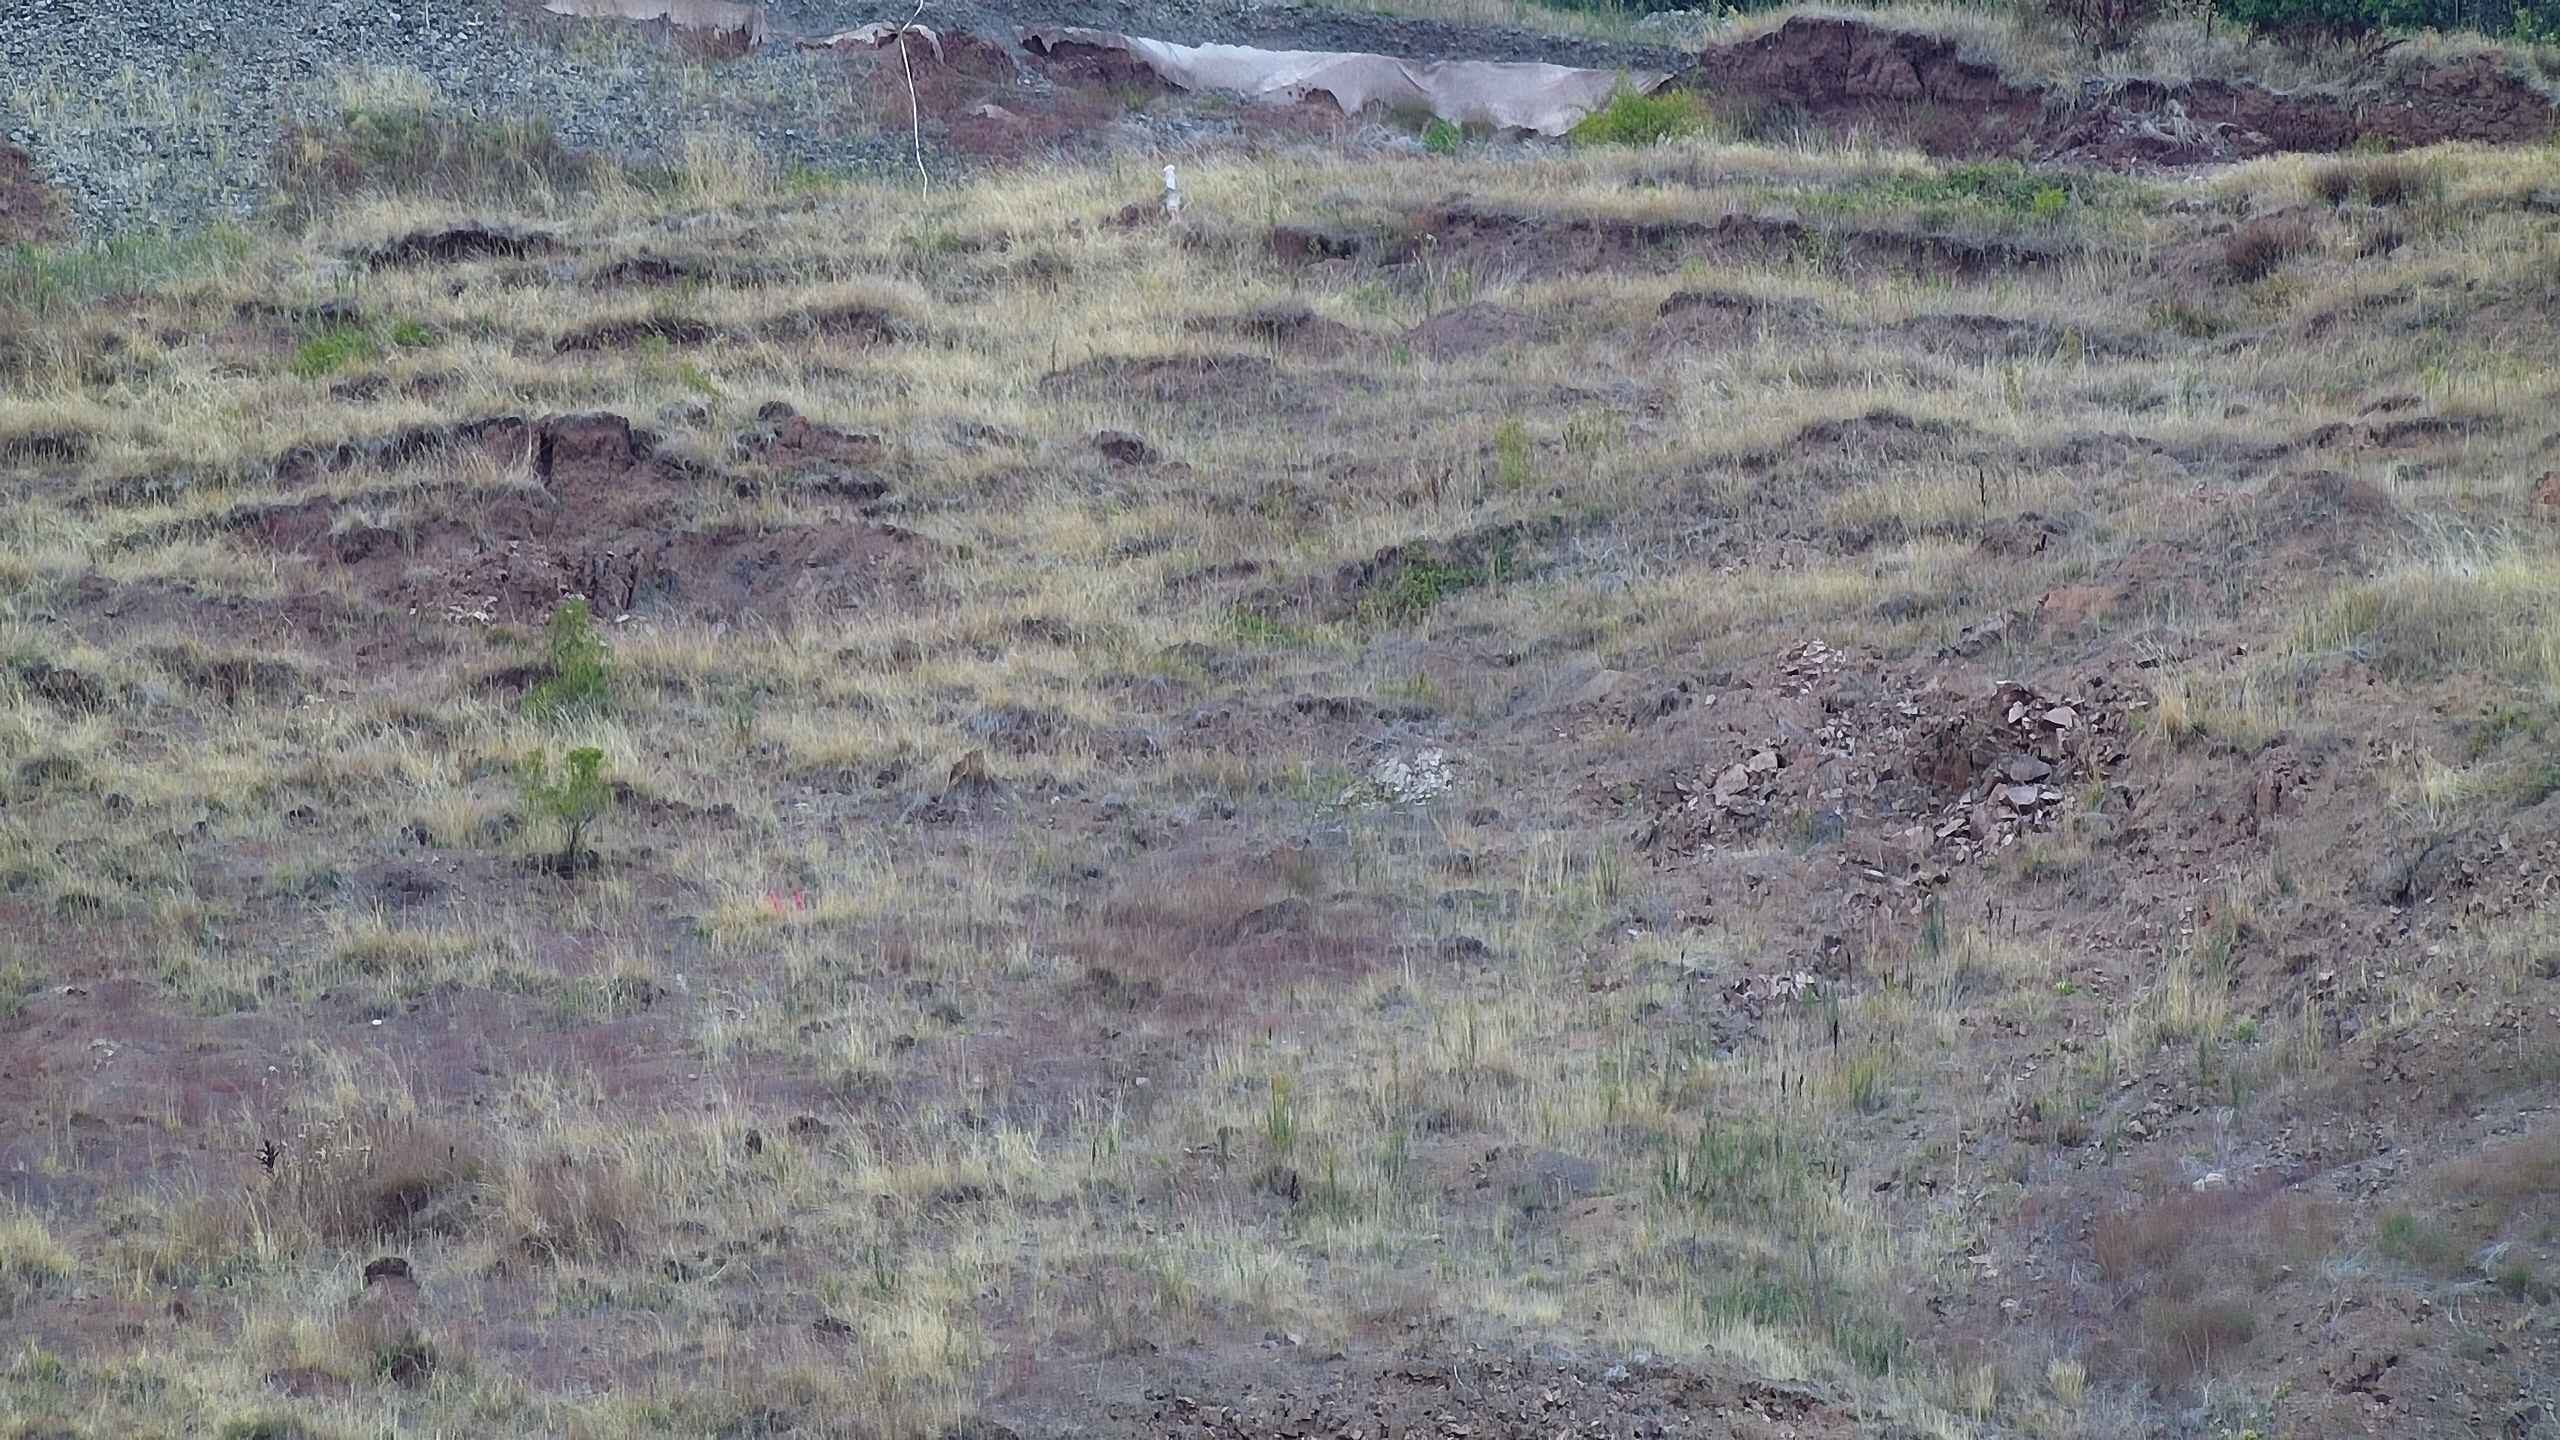

In [7]:
url, r = query_image(1,3,1,1, show_image = True)

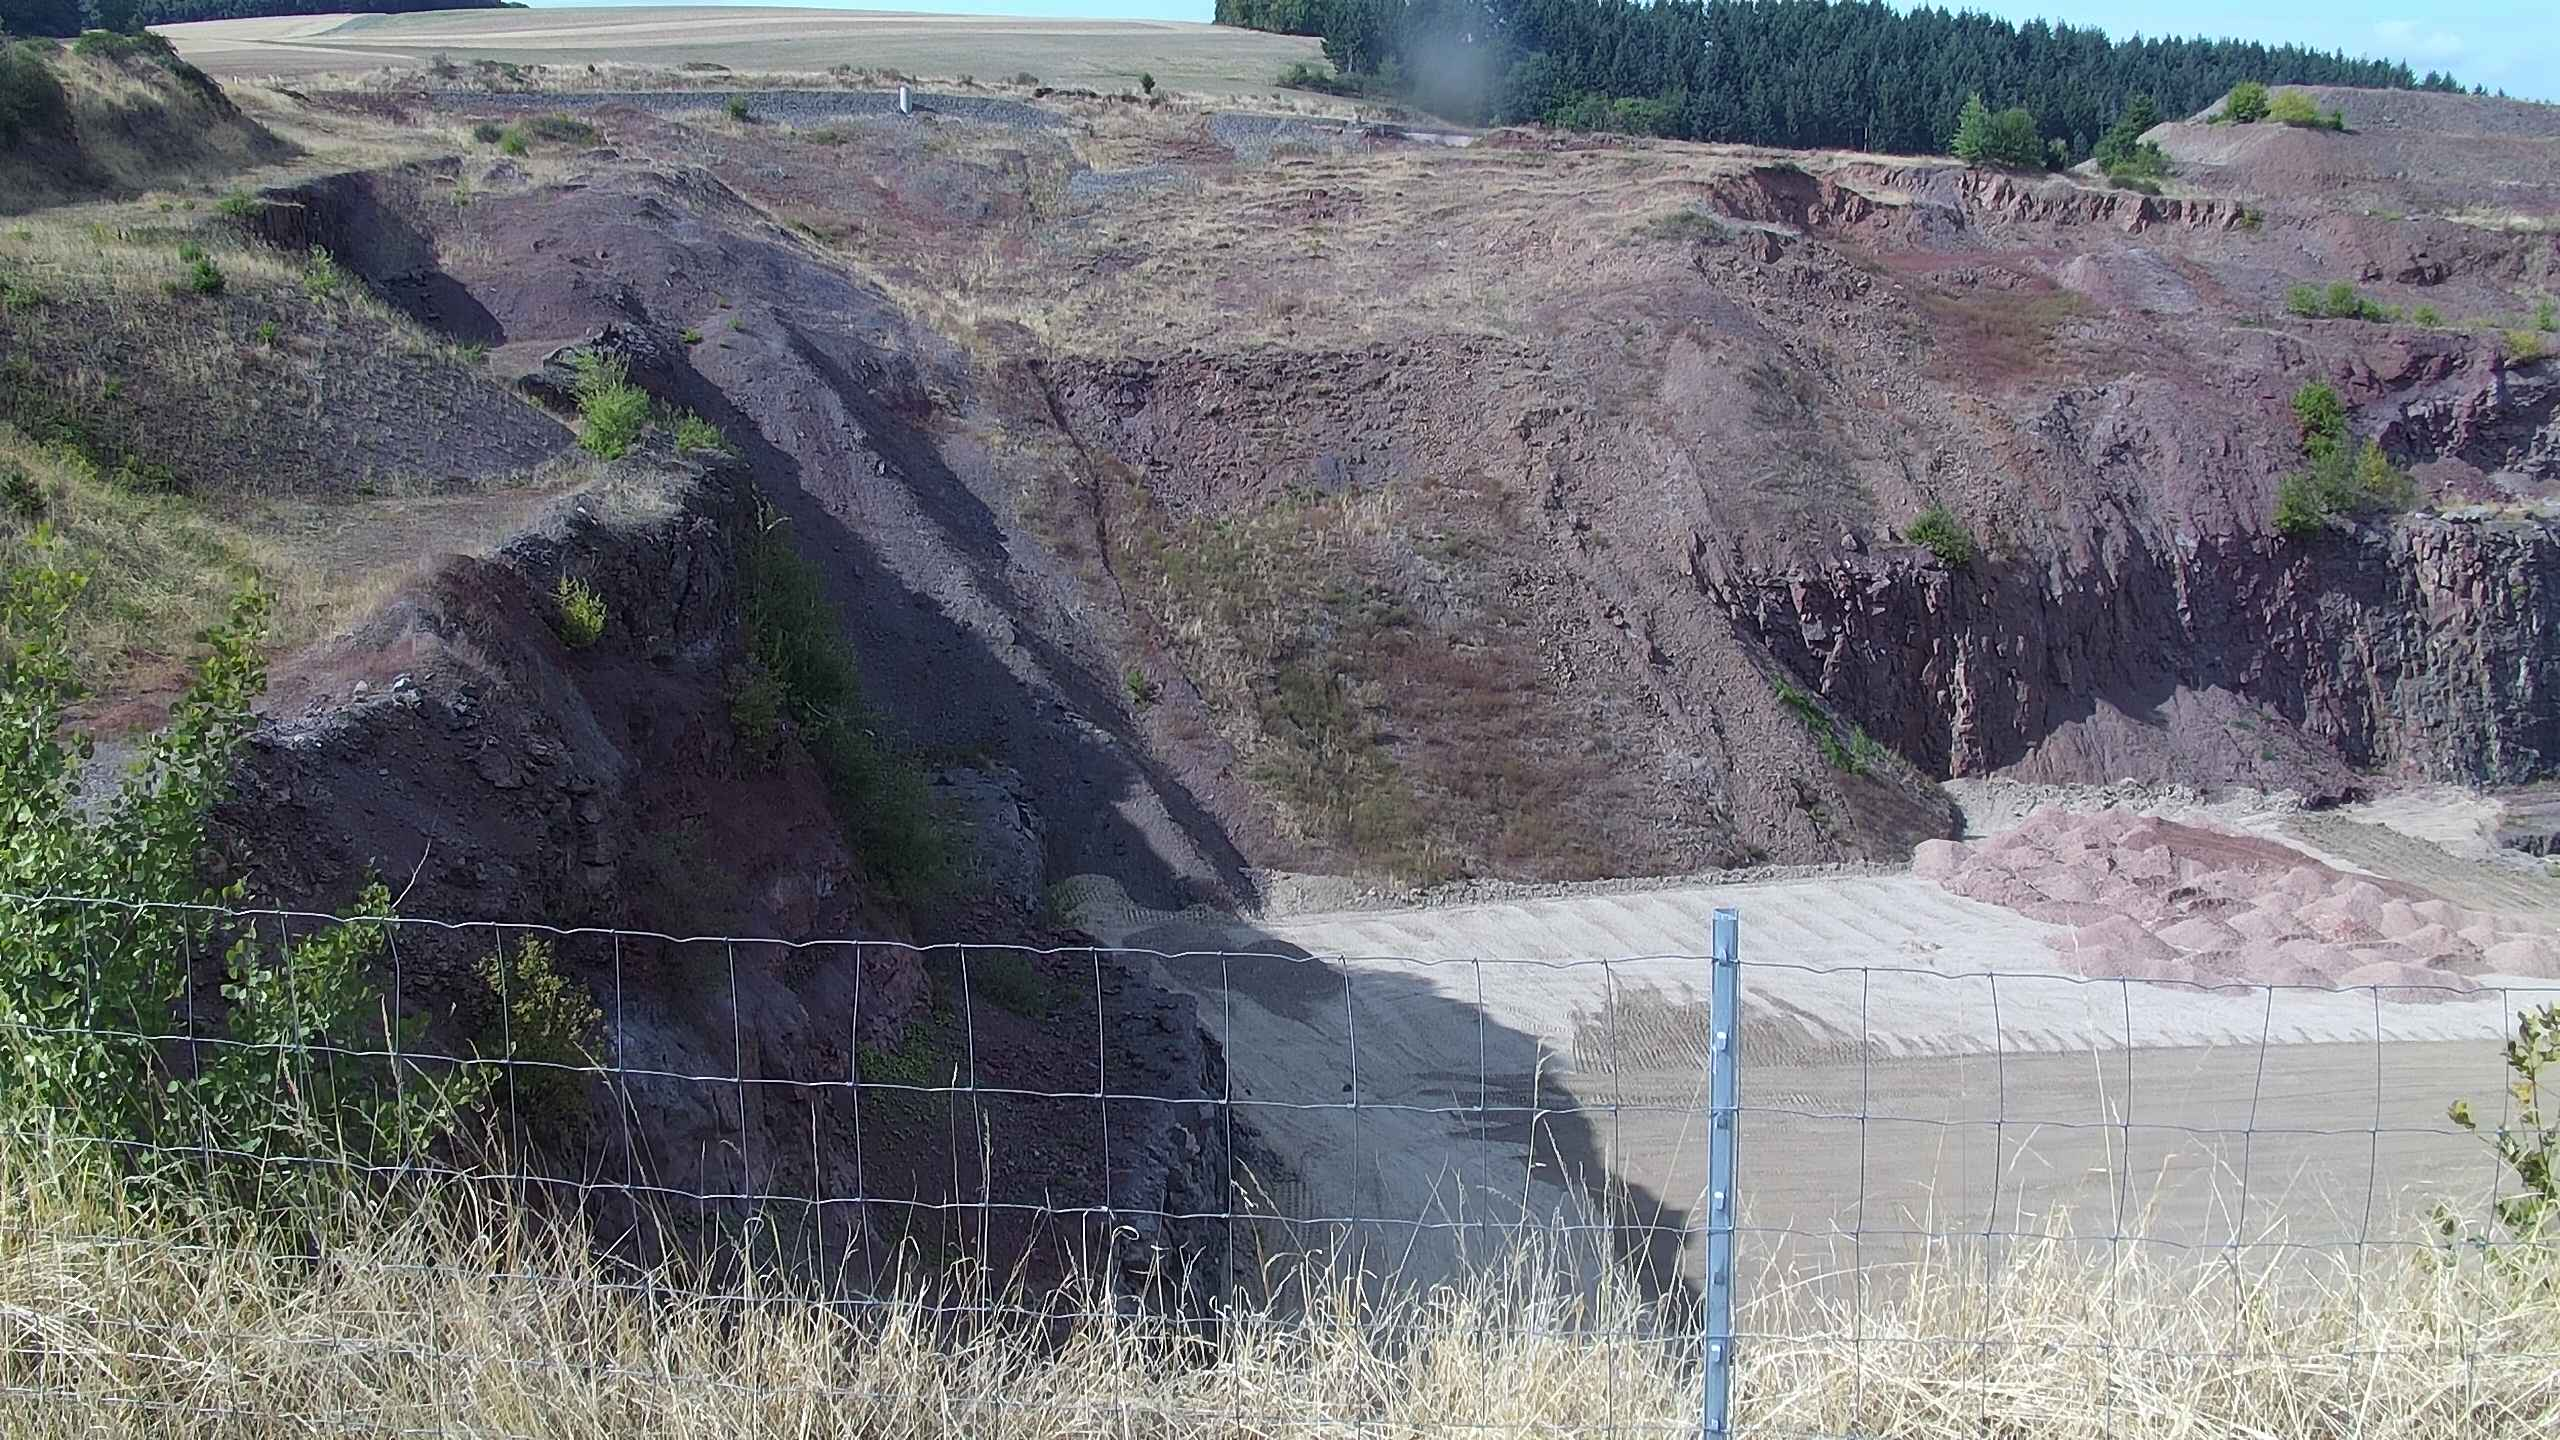

In [8]:
# use util function and query specifc timestamp
url, r = util.query_image(0,1,1,1, "2022-08-31T14-00Z")
display(Image(r.content))

In [14]:
# A quick hacky solution to obtain all scans from a certain time span. Added to src
def strip_scans(d, query):
    
    # copy dict
    d_copy = copy.deepcopy(d)

    query = str(query)
    temp_val = [value for value in d_copy if query in value["ScanName"]]
    values = [i['ScanName'] for i in temp_val]
    
    return values, d

In [10]:
# Let's query all timestamps from 5th of May 2022
test_query, d = strip_scans(d, "2022-05-05")
test_query

['2022-05-05T09-00Z', '2022-05-05T11-00Z', '2022-05-05T14-00Z']

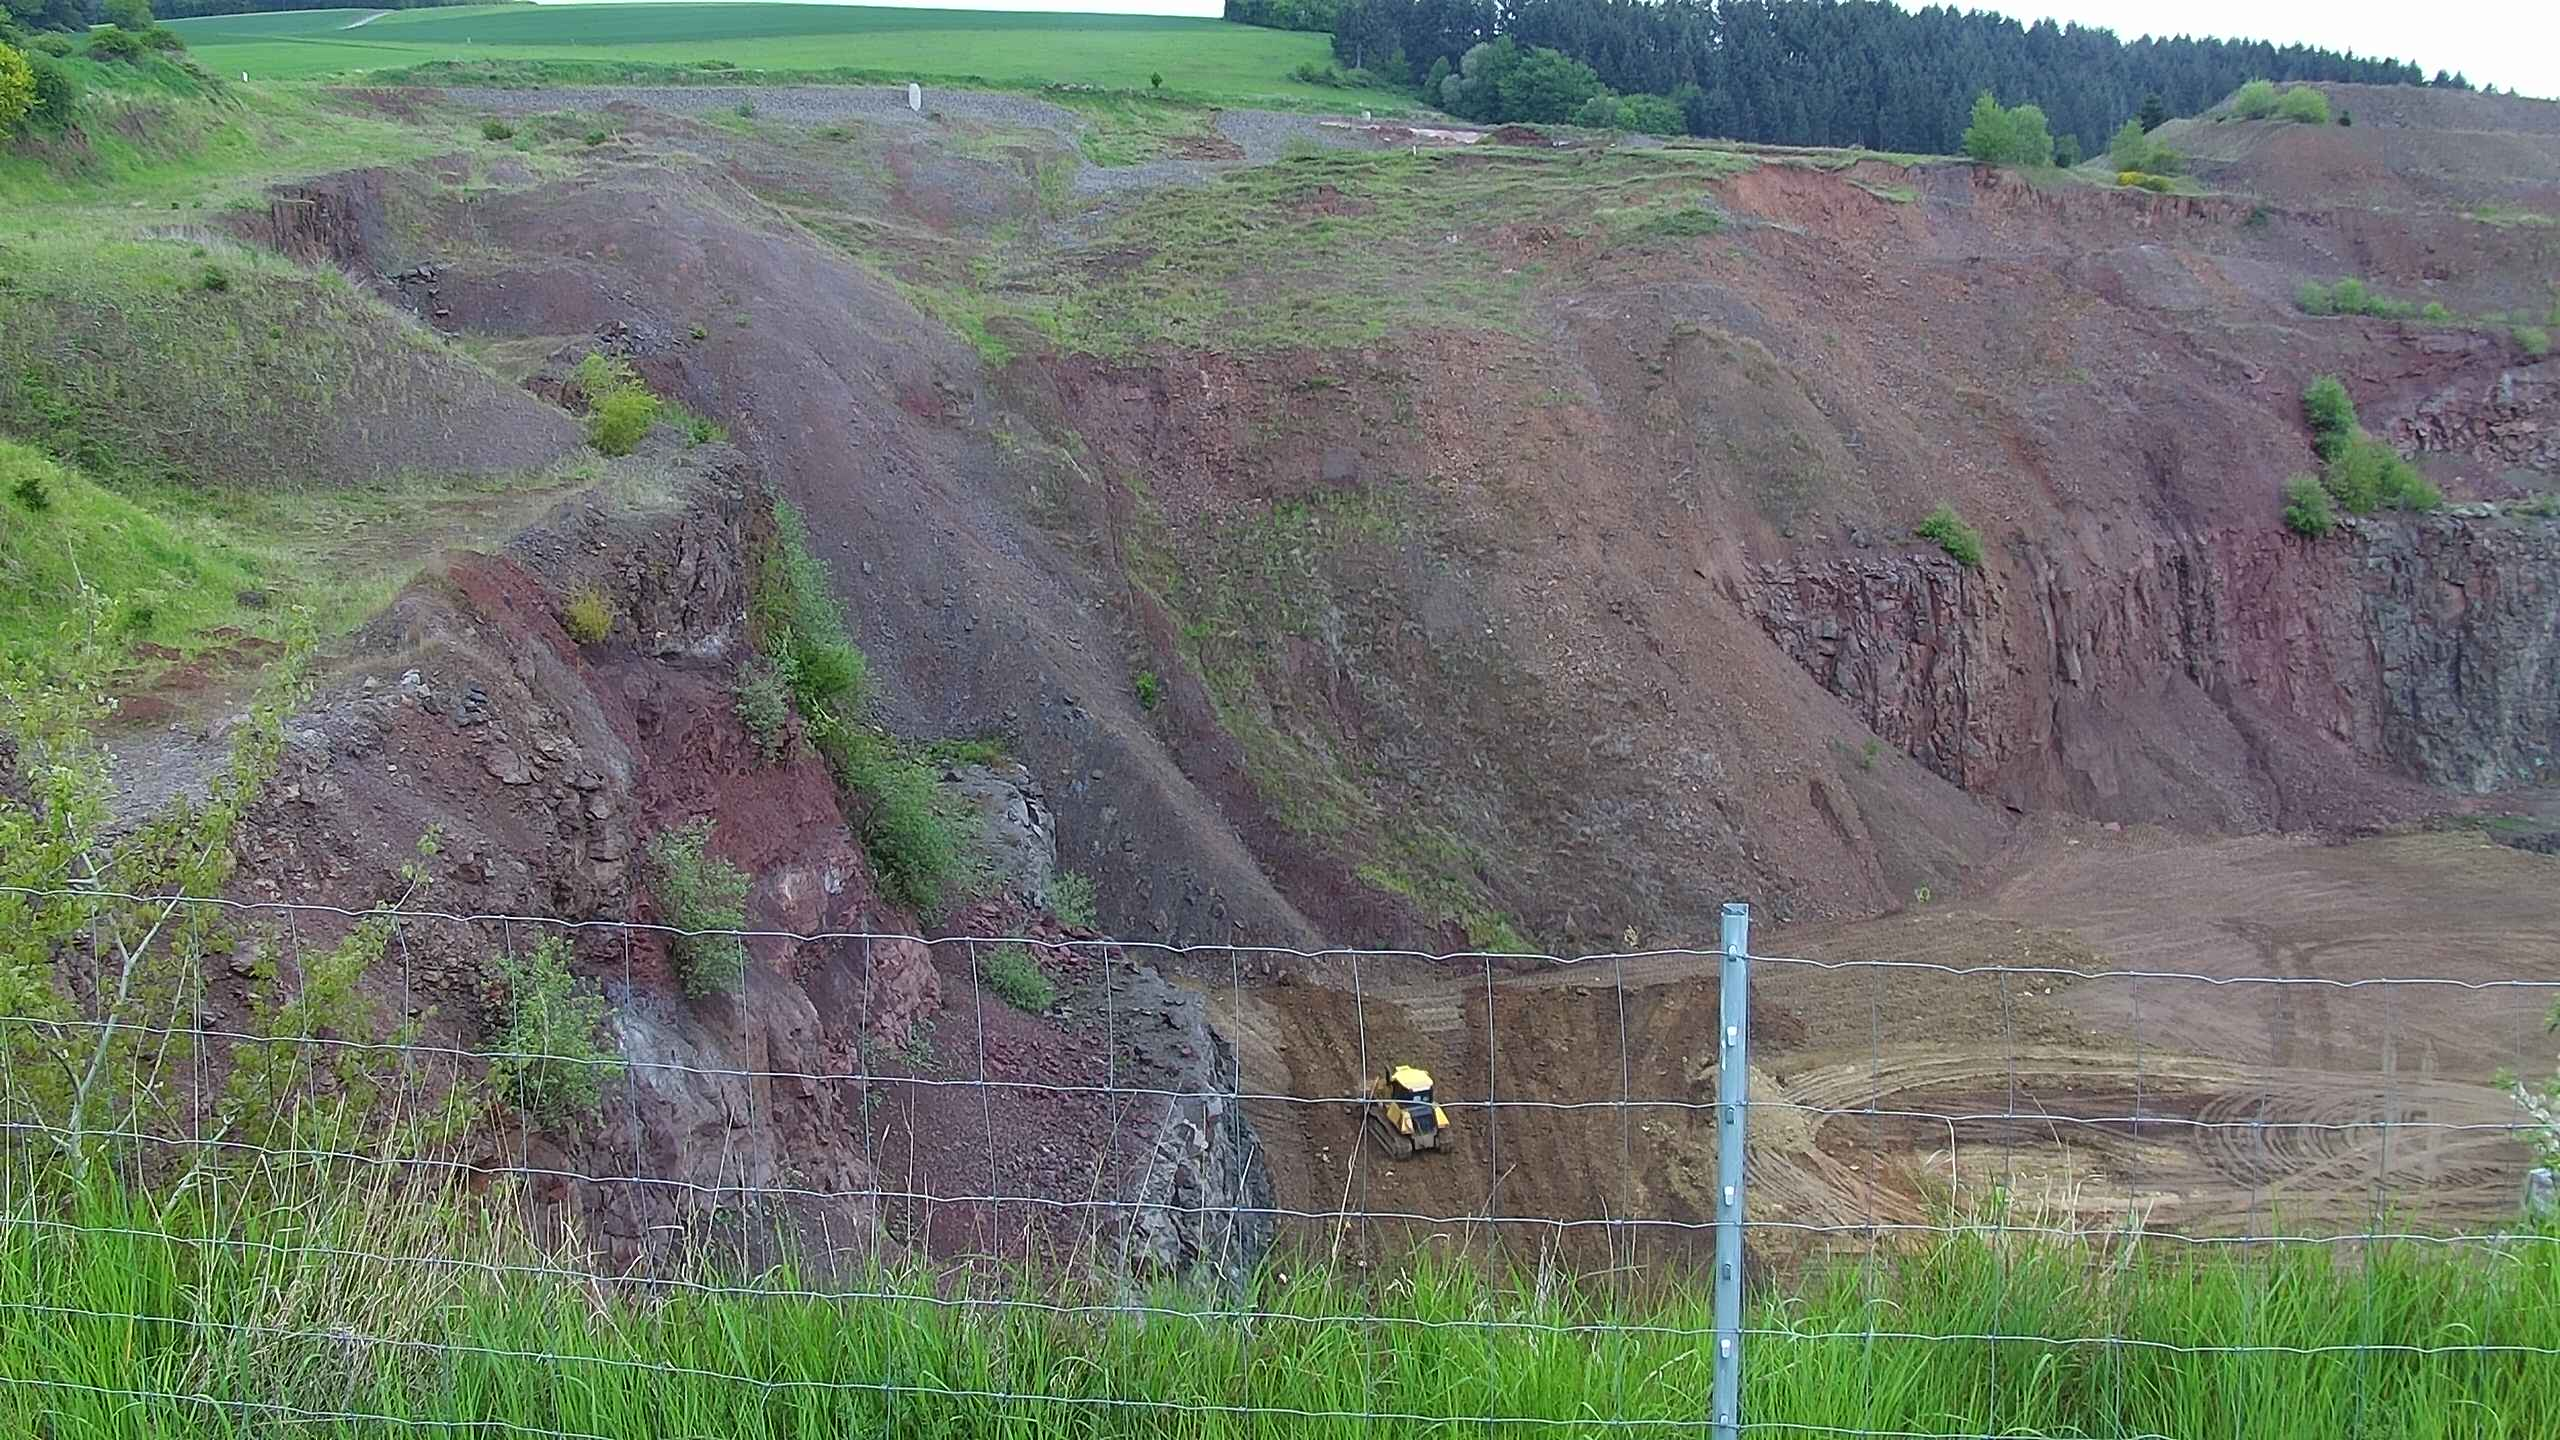

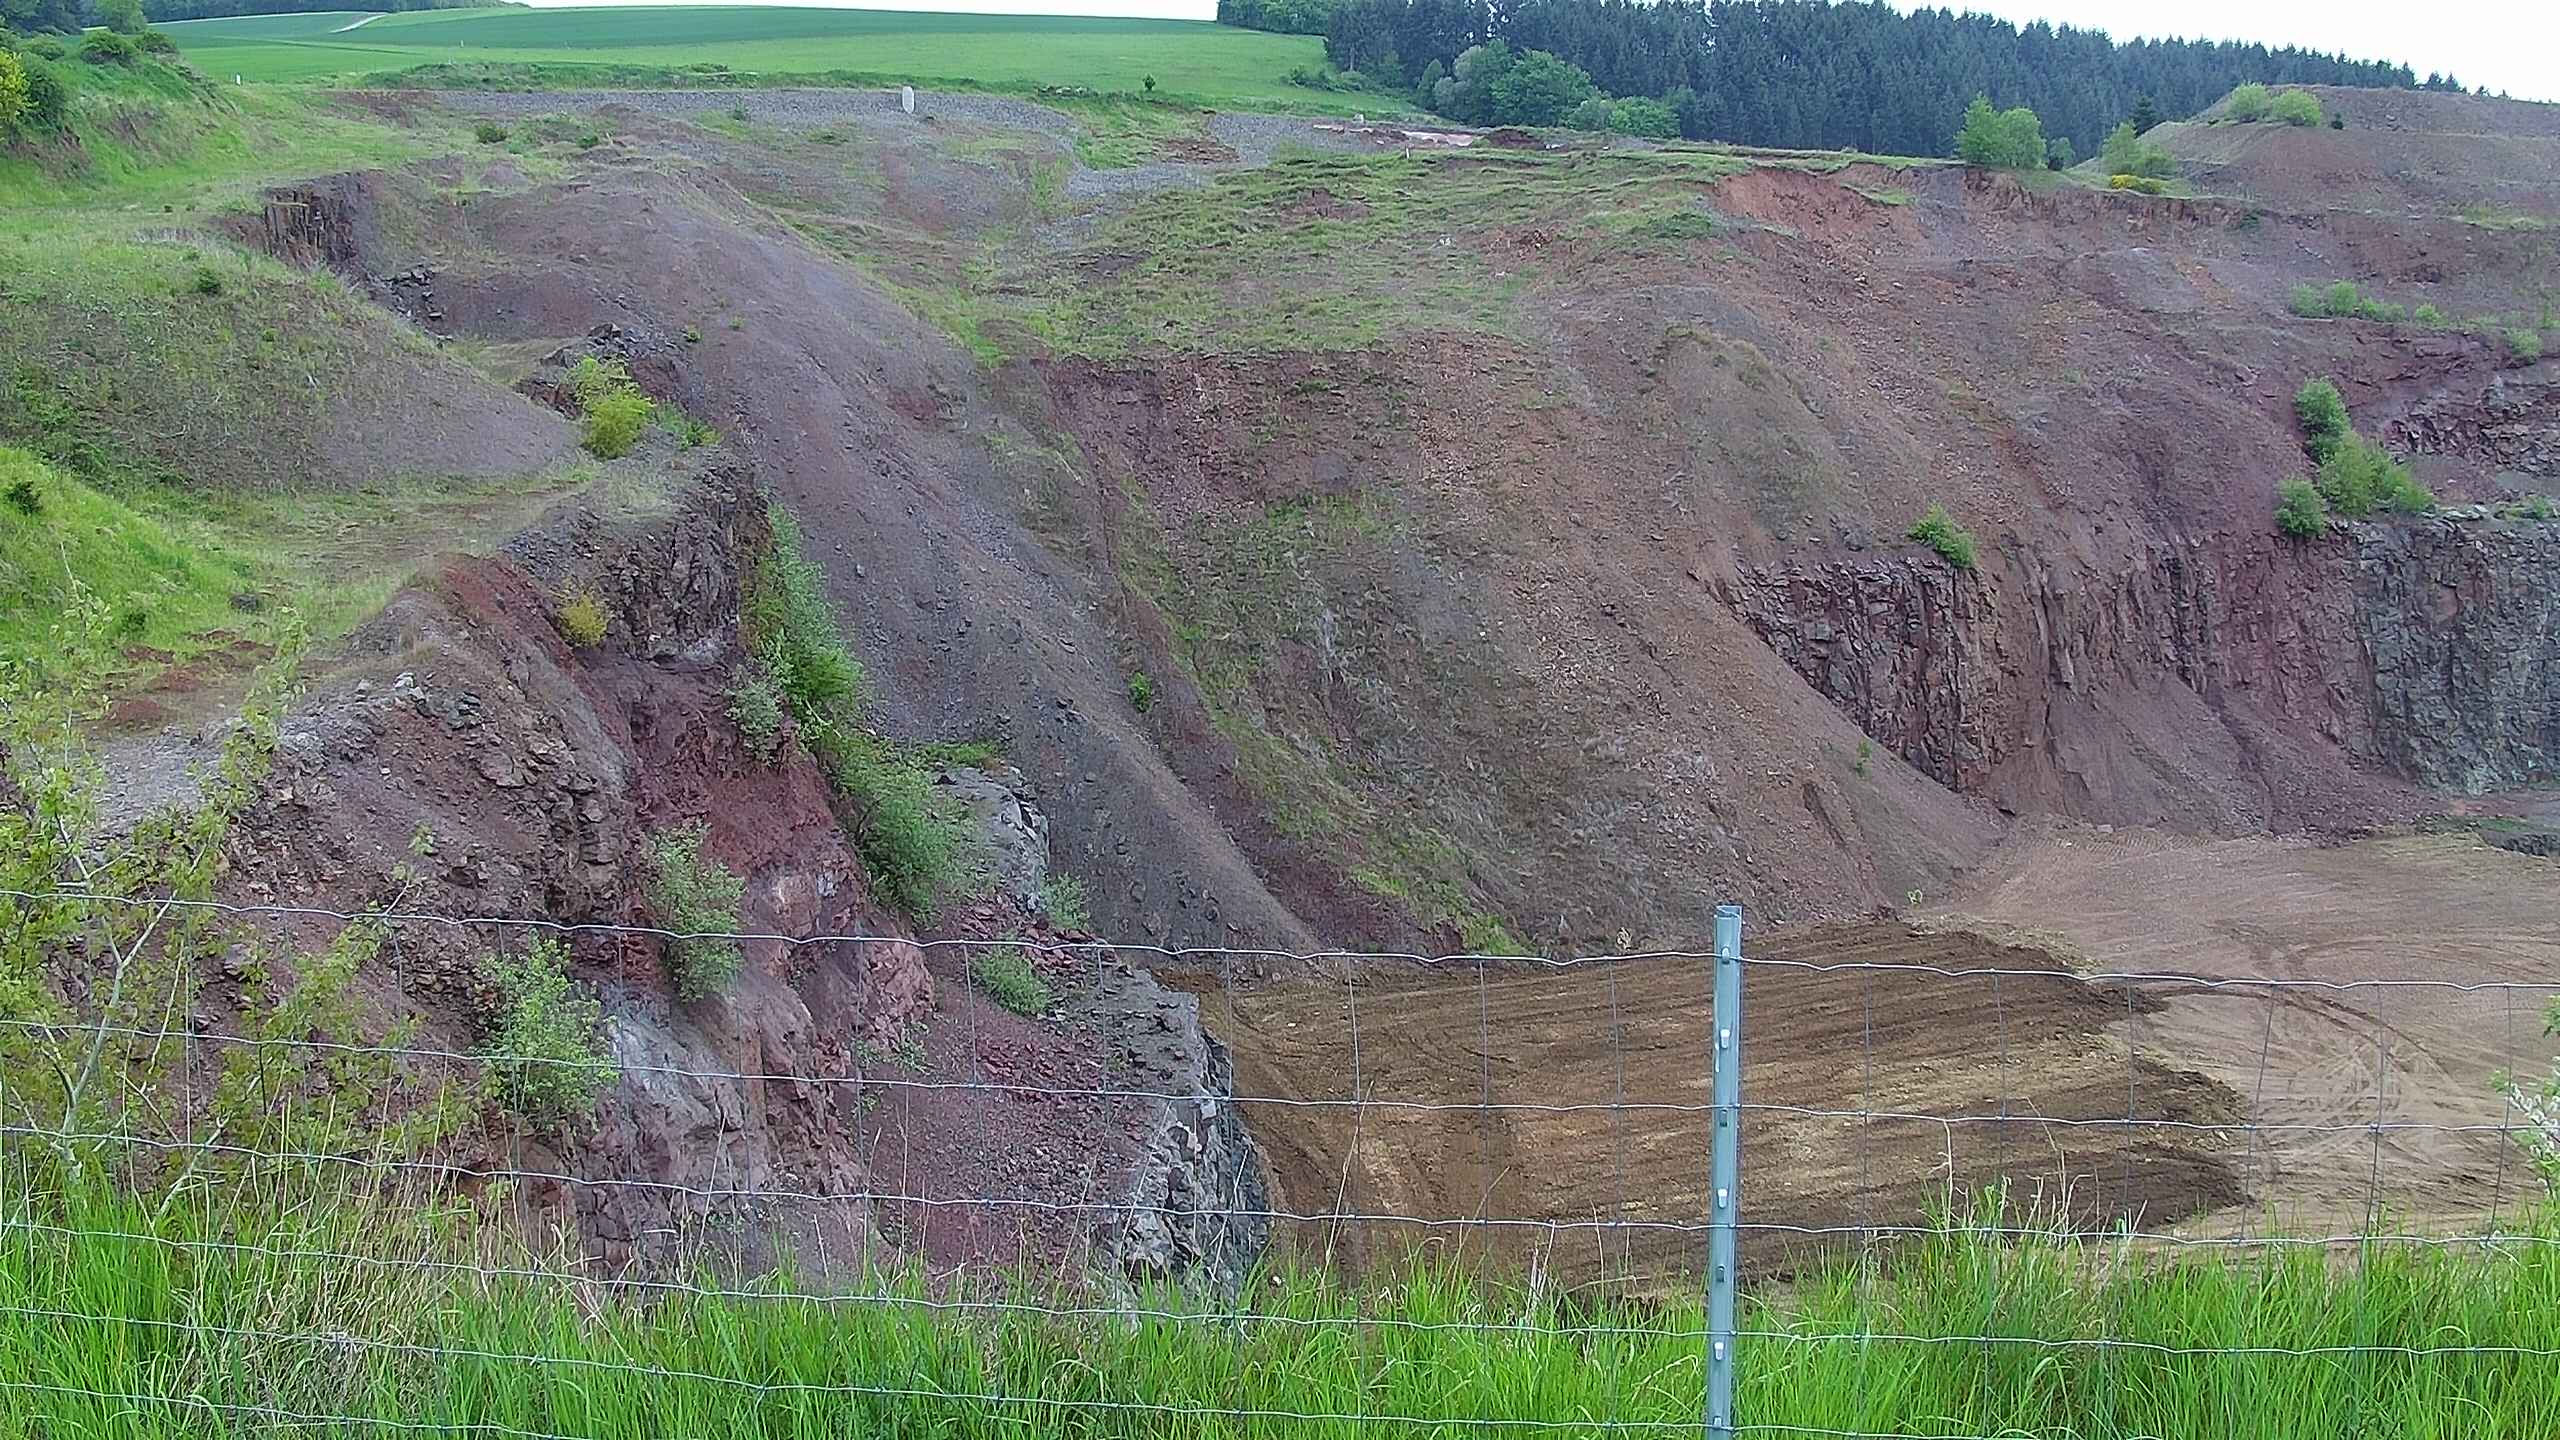

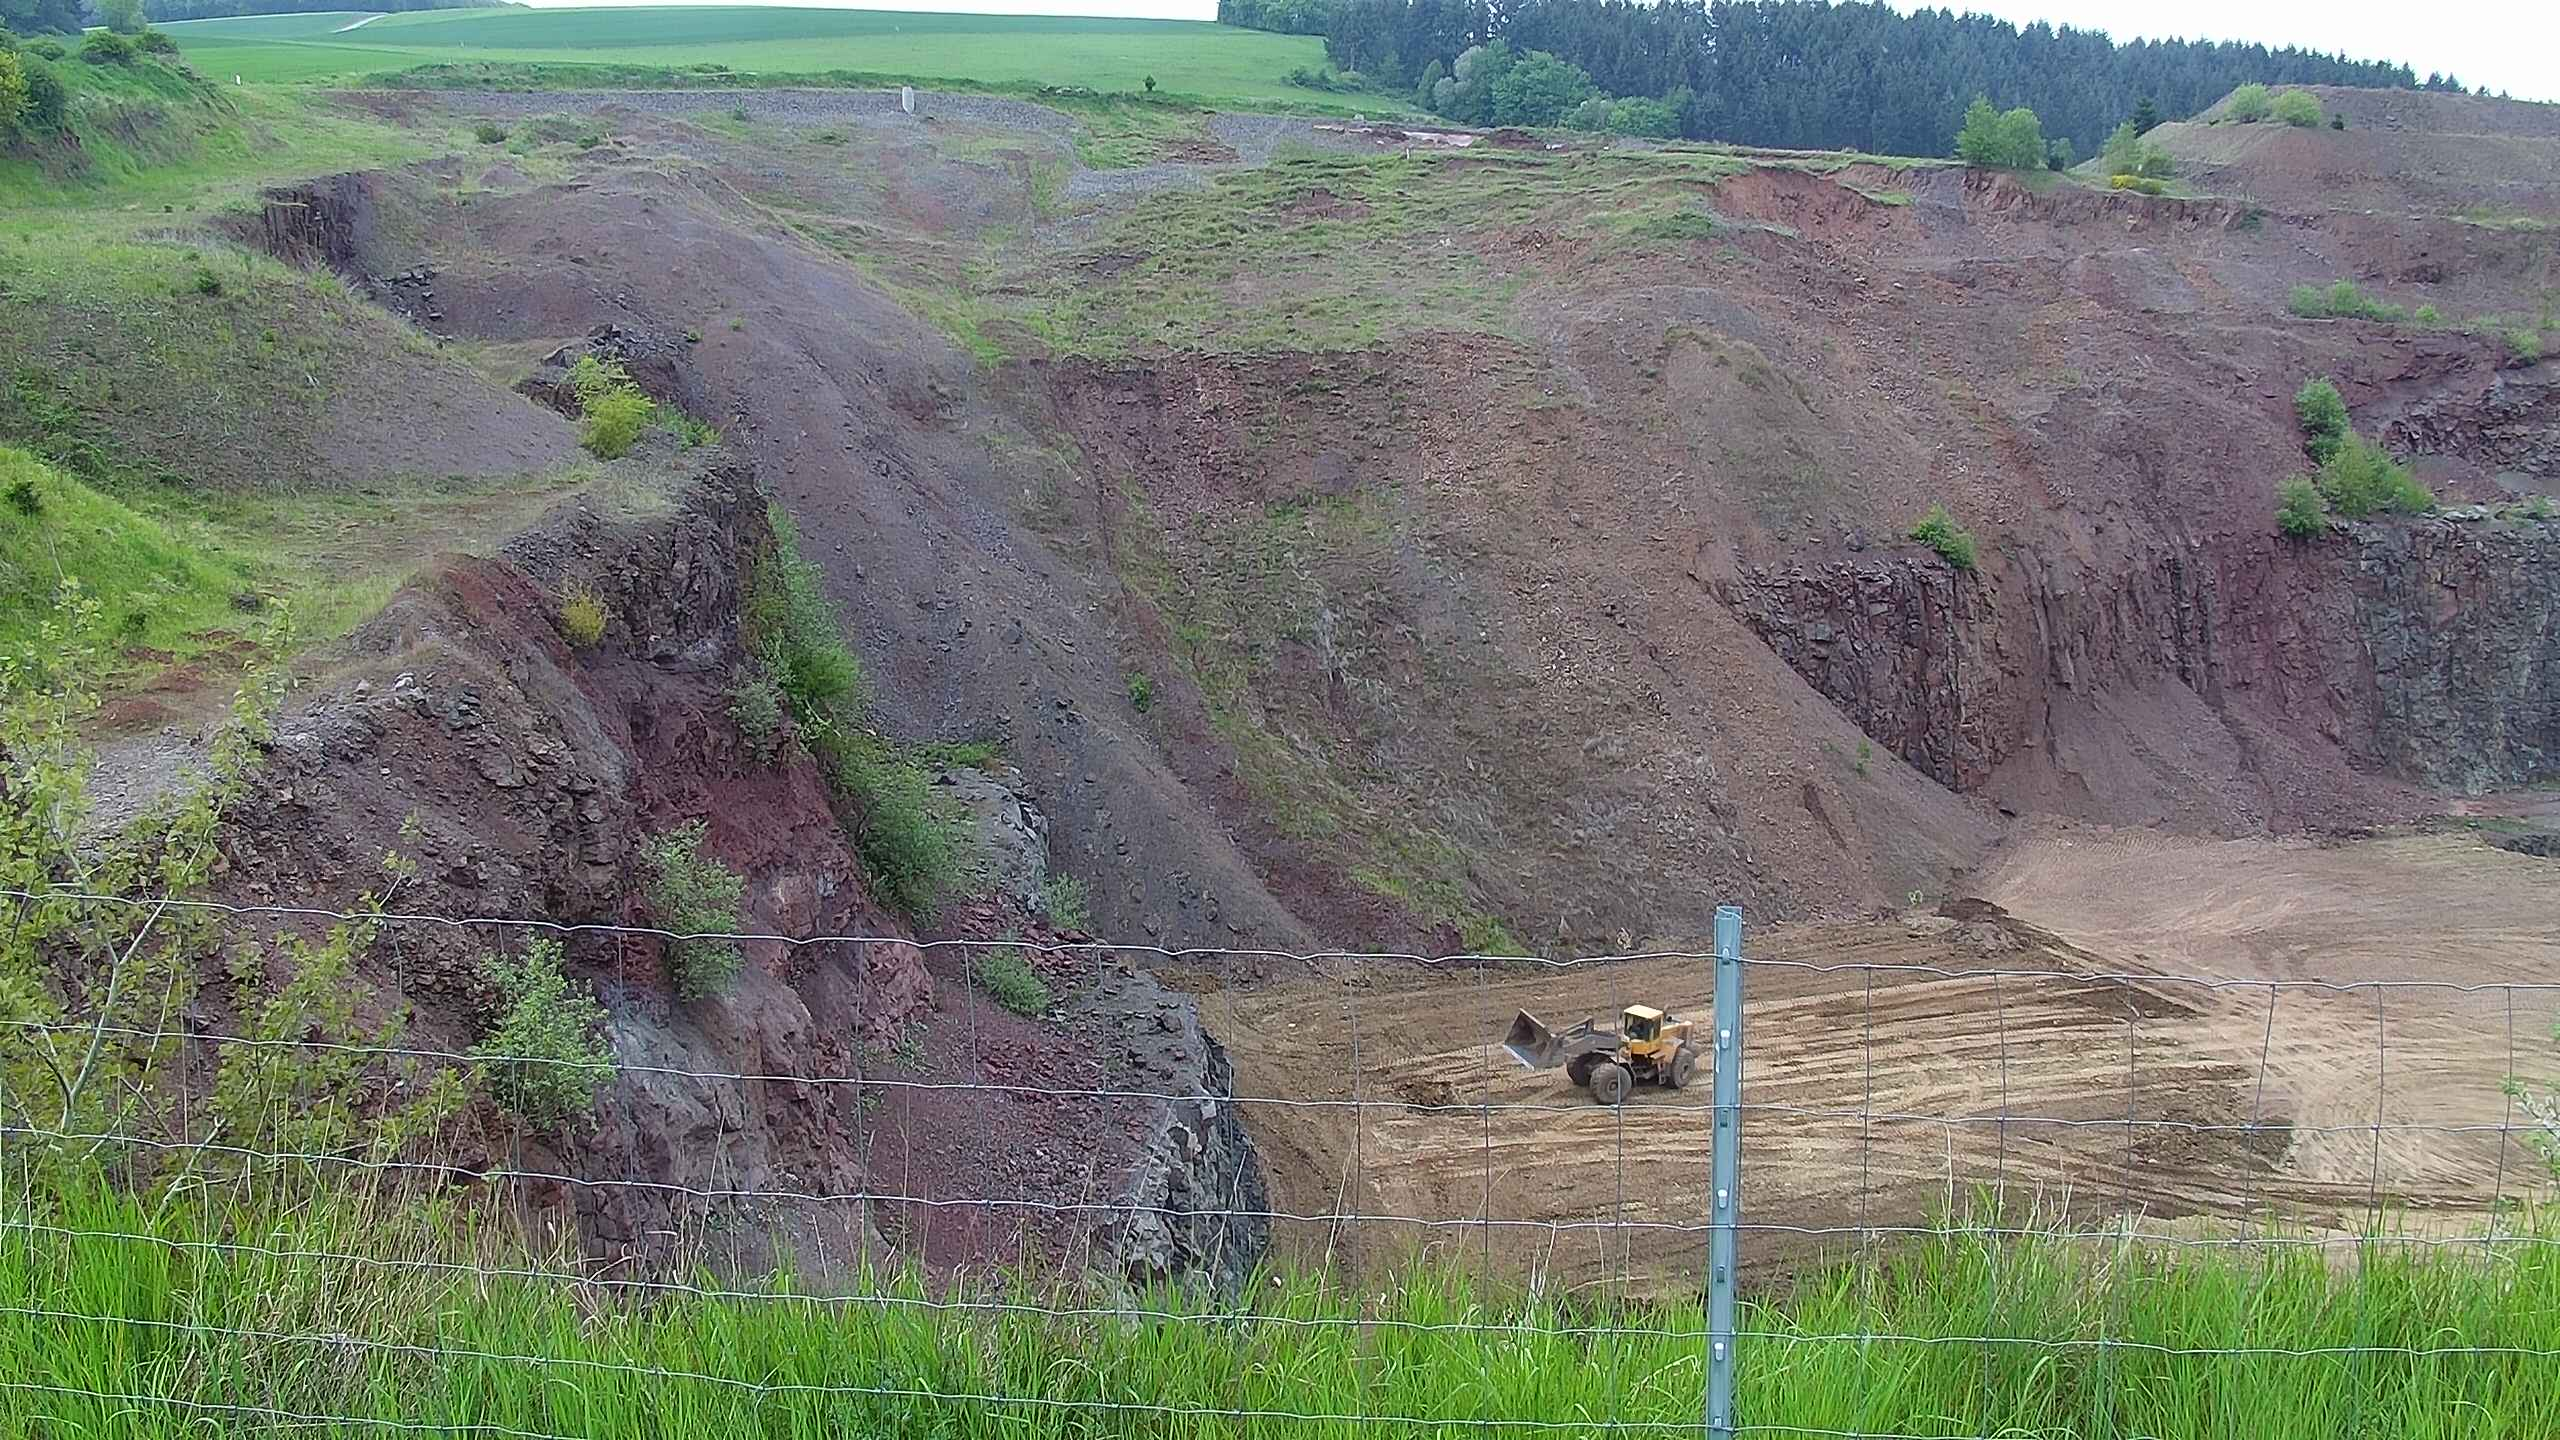

In [11]:
# Let's get all images from this day:
for i in test_query:
    url, r = util.query_image(0,1,1,1, i)
    display(Image(r.content))

In [13]:
# Let's query all timestamps from 5th of May 2022
test_query, d = util.strip_scans(d, "2022-05-05")
test_query

['2022-05-05T09-00Z', '2022-05-05T11-00Z', '2022-05-05T14-00Z']

# Notes and To-Dos
* Figure out structure - how to query tiles
* Store images (just to figure out the basics - gotta push them to DFKI hub anyways for processing)
* Build vector representations directly in query function and return indexed dataframe with timestamp as index and vector representation as features. 